In [31]:
#Installing all dependencies

import strawberryfields as sf
from strawberryfields.ops import *
# from strawberryfields.utils import scale
from numpy import pi, sqrt
import math
import random
from scipy.optimize import minimize

import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import simps

In [32]:
# from scipy.integrate import simps

# sf.hbar = 0.5
# # eng = sf.Engine("fock", backend_options={"cutoff_dim":10})
# eng = sf.RemoteEngine("simulon_gaussian")
# prog = sf.Program(2)

# with prog.context as q:
    
#     Fock(2) | q[0]

# state = eng.run(prog), run_options={"eval": False}).state
# wigner = a = state.wigner(0, [i/10 for i in range(-40, 40)], [i/10 for i in range(-40, 40)])

Now, let's compose our integrating method. Notice how when we sample Wigner function values, we only get points ranging from $-4$ to $4$. The peak of our distribution should be around $1$, so outisde of these bounds (especially $-4$), the probability of any measurement will be practically $0$, thus we approximate $\pm \infty$ to $\pm 4$. We have to integrate across each set of points with the same value of $x$, as this will give us the **total probability** of measuring that specific value of $x$, for any arbitrary value of $p$. Thus, we have:

In [33]:
# x = [i/10 for i in range(-40, 40)]

# def wigner_transform(x, wigner):

#     y = []

#     for i in range(0, len(x)):
#         res = simps([wigner[k][i] for k in range(0, len(x))], x)
#         y.append(res)

#     return y

# data = wigner_transform(x, wigner)

Finally, we have to plot our data as a quadrature graph:

In [34]:
# plt.plot(x, data)
# plt.xlabel("Value of X")
# plt.ylabel("Probability")

# plt.show()

It works!

**Simulating Continuous-Variable QAOA For a Simple Problem** <div id="5"></div>

Now that we understand why QAOA/VQE actually work, let's try to implement a basic simulation of the algorithm for a basic cost function. Consider the horizontally translated parabloa:

<br><br>
$$f(x) \ = \ (x \ - \ a)^2$$
<br><br>

We can easily translate this to the language of "quantum cost Hamiltonians" with the method outlined in the previous section to get:

<br><br>
$$\hat{H}_{C} \ = \ (\hat{x} \ - \ a)^2$$
<br><br>

For our circuit, the unitary $U(\alpha, \ \gamma)$ is given as:

<br><br>
$$U(\alpha, \ \gamma) \ = \ e^{-i \alpha \hat{H}_{M}} e^{-i \gamma (\hat{x} \ - \ a)^2} \ \Rightarrow \ \hat{H}_{M} \ \in \ \{ \hat{H}_{K}, \ \hat{H}_{N} \}$$
<br><br>

In order to implement this on a photonic quantum circuit, we need to express these unitaries in terms of products of gates in the allowed gate set for our quantum computer. For our simulations, we will be using Strawberry Fields, so we are confined to the gate state that the Strawberry Fields library provides (we can technically make custom gates, but that feels like cheating). Anyways, let's expand and **separate**. Now, I hope you're saying (unless you're on step ahead of me): "Jack, separating a matrix exponential??? Don't you need an infinite number of terms for the Baker-Campbell-Hausdorff expansion???". Well, the answer is yes, but practically all of those terms end up being equal to one. The operators $\hat{x}^{n}$ and $\hat{x}^{m}$ will commute, thus Baker-Campbell-Hausdorff greatly reduces, ands we get:

<br><br>
$$e^{-i \gamma (\hat{x} \ - \ a)^2} \ = \ e^{-i \gamma (\hat{x}^2 \ - \ 2a\hat{x} \ + \ a^2)} \ = \ e^{-i \gamma \hat{x}^2} e^{i \gamma 2a \hat{x}} e^{-i \gamma a^2} \ \Rightarrow \ e^{-i \gamma \hat{x}^2} e^{i \gamma 2a \hat{x}}$$
<br><br>

We just dropped the exponential $e^{-i \gamma a^2}$ because it is an overall phase and does not affect our quantum state. Conceptually, this makes sense, as $a^2$ simply acts to shift our entire parabola vertically, not affecting the $x$-coordinate of the global minimum, thus we mught as well drop it from the cost function (we'll keep it in there for the classical post-processing). We have two gates that we need to act upon a photonic mode. In order to implement these unitaries on the quantum circuit, we express them as momentum displacement and quadratic phase operator. First, the momentum displacement operator is defined as:

<br><br>
$$Z(p) \ = \ \exp(i p \hat{x}/ \hbar)$$
<br><br>

So we then have:

<br><br>
$$e^{i \gamma 2a \hat{x}} \ \Rightarrow \ 2\gamma a \ = \ \frac{p}{\hbar} \ \Rightarrow \ p \ = \ 2 \gamma a \hbar$$
<br><br>

We also utilize the quadratic phase gate:

<br><br>
$$P(s) \ = \ \exp \Big( i \frac{s}{2\hbar} \hat{x}^2 \Big) \ \Rightarrow \ e^{-i \gamma \hat{x}^2} \ \Rightarrow \ -\gamma \ = \ \frac{s}{2\hbar} \ \Rightarrow \ s \ = \ -2 \gamma \hbar$$
<br><br>

We can code this up in Strawberry Fields! First, we have to initialize the value of Planck's constant, as well as the value of $a$. For now, we will pick some arbitrary value (I chose $0.83$). You can change this later, if you want to convince yourself that the algorithm works for other values of $a$ as well:

In [35]:
eng = sf.RemoteEngine("simulon_gaussian")

In [36]:
#Defines the value of h-bar

sf.hbar = 0.5
hbar = 0.5

#Defines the value of the parabolic minimum

parabolic_min = 0.83

We will now define our classical cost function, which is fairly easy in Python:

In [37]:
#Defines the classical cost function

def function_optimize(x, parabolic_min):
    y = (x - parabolic_min)**2
    return y

We now have to define our cost unitary, to be used in the QAOA process, which again, we can do fairly easily:

In [38]:
#Defines the cost unitary for QAOA

def cost_ham(q, p):

    Zgate(parabolic_min*2*hbar*p) | q[0]
    # Pgate(-2*hbar*p) | q[0]
    Rgate(-np.pi/2) | q[0]
    Zgate(-2 * hbar * p) | q[0]
    Rgate(np.pi/2)  | q[0]

Now we can turn our attention to implementing the mixer Hamiltonian. Let's start with the kinetic mixer, then move to the number mixer. In order to implement this gate, we simply perform a Fourier gate-operation on both sides of the qudratic phase gate:

<br><br>
$$\exp \Big( i \frac{s}{2\hbar} \hat{p}^2 \Big) \ = \ \exp \Big( i \frac{s}{2\hbar} F^{\dagger} \hat{x} F F^{\dagger} \hat{x} F \Big) \ = \ \exp \Big( i \frac{s}{2\hbar} F^{\dagger} \hat{x}^2 F \Big) \ = \ \displaystyle\sum_{i \ = \ 0}^{\infty} \frac{(i \frac{s}{2\hbar})^{i} (F^{\dagger} \hat{x}^2 F)^{i}}{i!} \ = \ F^{\dagger} \displaystyle\sum_{i \ = \ 0}^{\infty} \frac{(i \frac{s}{2\hbar})^{i} (\hat{x}^2)^{i} }{i!} F \ = \ F^{\dagger} P(s) F$$
<br><br>

If the removal of those Fourier operations from the sum made you do a double-take, never fear! Consider the following:

<br><br>
$$M N^n M^{-1} \ = \ M (N \mathbb{I})^n M^{-1} \ = \ M (N M^{-1} M)^n M^{-1} \ = \ (M N M^{-1})^n$$
<br><br>

Since $F^{\dagger}$ is the inverse of $F$, as these operations are unitary, the same logic follows. We can then code this into our Strawberry Fields program, with the parameter $s \ = \ -\frac{1}{2} \hbar \alpha$:

In [39]:
#Defines the kinetic mixer unitary for QAOA

def mixer_ham(q, p):

    Rgate(-1*math.pi/2) | q[0]
    # Pgate(-1*hbar*p) | q[0]
    Rgate(-np.pi/2)     | q[0]
    Zgate(-hbar * p)    | q[0]
    Rgate(np.pi/2)      | q[0]

    Rgate(math.pi/2) | q[0]

    return q 

We have a few more parameters that we have to define as well before we run our simulation. We have to choose our circuit depth, which is the number of times the cost-mixer unitary is applied and the photon cutoff dimension for our Strawberry Fields simulation. In addition, we have to choose our **squeezing parameter**. We will be initializing our simulation in a squeezed state over the $x$-quadrature, in order to ensure that our algorithm searches over a large space of possible solutions:

In [40]:
#Defines the circuit depth, cutoff dimension, and the squeezing parameter

circuit_depth = 3
squeezing = -0.5
cutoff = 5

Now, we are in a position to define our first circuit, which will return numerical values for our graphical visualization. Note that this is not the function that we will be using for the actual optimization of the circuit, as this function does not sample the circuit, but rather returns Wigner function values for our graph.  We will find Wigner function values ranging from $-30$ to $30$, for both the $x$ and $p$ quadratures, with a spacing of $0.1$ between measured values. In addition, we will only optimize over one parameter, as the function we are optimizing is a fairly simple one:

In [41]:
#Defines the function used to run the circuit and return numerical data

def run_circuit(param):

    # eng = sf.Engine("fock", backend_options={"cutoff_dim":cutoff})
    prog = sf.Program(1)

    param1 = [param[0] for i in range(0, circuit_depth)]
    param2 = [param[0] for i in range(0, circuit_depth)]

    with prog.context as q:

        Squeezed(squeezing,0) | q[0]

        for i in range(0, circuit_depth):

            cost_ham(q, param1[i])
            mixer_ham(q, param2[i])

    result = eng.run(prog, shots=100) # run_options={"eval": False})
    state = result.state
    a = state.wigner(0, [i/10 for i in range(-30, 30)], [i/10 for i in range(-30, 30)])
    return a

Next, we will define our "sampling function", which is identical to the one that we just provided, except instead of returning numerical Wigner function values, we will actually sample the circuit for individual values:

In [42]:
#Defines the sampling circuit simulation

def old_circuit(param):

    # eng = sf.Engine("fock", backend_options={"cutoff_dim":cutoff})
    prog = sf.Program(1)

    param1 = [param[0] for i in range(0, circuit_depth)]
    param2 = [param[0] for i in range(0, circuit_depth)]

    with prog.context as q:

        Squeezed(squeezing,0) | q[0]

        for i in range(0,circuit_depth):

            cost_ham(q, param1[i])
            mixer_ham(q, param2[i])

        MeasureX | q[0]

    result = eng.run(prog, shots=1)
    return result.samples[0][0]

We now have to specify how many times we will sample the circuit, to obtain a decently accurate value for the expectation value of our cost Hamiltonian. For now, we will choose $15$ as the number of our samples.

In [43]:
#Defines the number of iterations that the circuit is sampled

shots = 15

We now have to define our **objective function**, which is the function that we will attempt to optimize with our classical optimizer. As the cost, we will return the average of our repeated samples of the circuit:

In [44]:
#Defines the objective function that is minimized

def objective(param):

    costly = 0

    for i in range(0, shots):

        av = old_circuit(param)
        result1 = av
        calculation = function_optimize(result1, parabolic_min)
        costly = costly + calculation

    costly = costly/shots


    print("Paramter: "+str(param))
    print("Value of Cost Function: "+str(costly))

    return costly

Next, we will define the actual classical optimizer that we will use to minimize the objective function. For this implementation, we will use the Nelder-Mead optimizer. For our initial parameter, we will choose a random value from $-3$  to $3$ (this was arbitrary, there is probably a better way to choose this initial parameter based on traditional gradient descent methods, but for now, a random value in this aarbitrary range will suffice). Finally, we will run our numerical circuit one more time with the optimal parameters, in order to get Wigner function values for our graphical visualization:

In [45]:
#Defines the optimizer that minimizes the objective function

out = minimize(objective, x0=[random.randint(-150,150)/100], method="Nelder-Mead", options={'maxiter':20})
print(out)

# #Creates the graphical visualization

# final = run_circuit(out['x'])

# x = [i/10 for i in range(-30, 30)]
# y = []


# for i in range(0, len(x)):
#     res = simps([final[k][i] for k in range(0, len(x))], x)
#     y.append(res)

# plt.plot(x, y)
# plt.plot([parabolic_min, parabolic_min, parabolic_min, parabolic_min, parabolic_min], [0, 0.25*max(y), 0.5*max(y), 0.75*max(y), max(y)])

# plt.show()

2025-06-29 01:45:37,257 - INFO - Compiling program for device simulon_gaussian using compiler gaussian.
2025-06-29 01:45:40,098 - INFO - The remote job 25f7282d-4b4e-40ac-a86f-8ea3a1e96148 has been completed.
2025-06-29 01:45:40,414 - INFO - Compiling program for device simulon_gaussian using compiler gaussian.
2025-06-29 01:45:44,840 - INFO - The remote job f665423b-0441-446c-bf9d-64b3e308b059 has been completed.
2025-06-29 01:45:45,149 - INFO - Compiling program for device simulon_gaussian using compiler gaussian.
2025-06-29 01:45:49,347 - INFO - The remote job 40d72af5-3f32-4b31-aa83-4d40469e5c04 has been completed.
2025-06-29 01:45:49,618 - INFO - Compiling program for device simulon_gaussian using compiler gaussian.
2025-06-29 01:45:52,730 - INFO - The remote job 3d68d22e-5414-4f41-9059-b360f31e2578 has been completed.
2025-06-29 01:45:53,007 - INFO - Compiling program for device simulon_gaussian using compiler gaussian.
2025-06-29 01:45:55,896 - INFO - The remote job 22aab3d8-11b

KeyboardInterrupt: 

In [ ]:
print(out)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.0745850236452489e-08
             x: [-4.699e-01]
           nit: 18
          nfev: 36
 final_simplex: (array([[-4.699e-01],
                       [-4.700e-01]]), array([ 1.075e-08,  1.697e-07]))


In [ ]:
print(out['x'])

[-0.46990625]


In [ ]:
# #Creates the graphical visualization

# final = run_circuit(out['x'])

# x = [i/10 for i in range(-30, 30)]
# y = []


# for i in range(0, len(x)):
#     res = simps([final[k][i] for k in range(0, len(x))], x)
#     y.append(res)

# plt.plot(x, y)
# plt.plot([parabolic_min, parabolic_min, parabolic_min, parabolic_min, parabolic_min], [0, 0.25*max(y), 0.5*max(y), 0.75*max(y), max(y)])

# plt.show()

2025-06-24 11:17:33,222 - INFO - Compiling program for device simulon_gaussian using compiler gaussian.
2025-06-24 11:17:36,104 - INFO - The remote job b3fc36ec-f6b3-48f7-8e8d-23f337a057aa has been completed.


AttributeError: 'NoneType' object has no attribute 'wigner'

So the optimizer performs decently well. As you can see, the $x$-quadrature has spiked pretty close to the optimal point, which is marked by the orange line!

You are welcome to play around further with other mixers, parameters, circuit depth, etc. to see what works the best before you proceed in this notebook, but for now, I'm going to move onto something a bit more interesting! For some reason, the optimizer does not do as well when $a$ is chosen outside the range of $-1$ to $1$, but this can be improved by playing around with the squeezing parameters, as well as the value of Planck's constant. For instance, let's increase the value of Planck's constant to one and try to run the simulation for a larger value of $a$ (I include the results as an image so I don't have to re-write all the code below). All other parameters were kept constant, except the value of Planck's constant, and the value of $a$, which is now $-1.41$:

<br>
<img src="image1.png" style="height:400px;">
<br>

As you can see, we get pretty decent results! It is important to note that when I was playing around with it, the optimizer was super finicky, and sometimes would not work. There are a lot of sources of error that could account for this, including limits in classical optimizers when sampling stochastic functions, low cutoff dimension, etc.

**Simulating Continuous-Variable QAOA For Harder Problems** <div id="6"></div>

Anyways, we have solved a very simple problem, but what if we want to solve something a bit more complex, like a question involving two variables? Well, we can implement that as well, but this time, we will have to use two optical modes instead of one, to encode both variables in our cost function. Let's try to minimize the function given by:

<br><br>
$$f(x, \ y) \ = \ (2x-y)^2 + (x-1)(y+1) \ = \ x^2 \ + \ y^2 \ + \ x \ + \ y \ + \ xy$$

$$\Rightarrow \ \min f(x, \ y) \ = \ -\frac{1}{3} \ \Rightarrow \ (x, \ y) \ = \ \Big( -\frac{1}{3}, \ -\frac{1}{3} \Big) \ \approx \ (-0.333333333, \ -0.333333333)$$
<br><br>

As far as more complex functions go, this one is fairly simple and "symetric" in terms of its minimum. We can put this in the form of our unitary:

<br><br>
$$U(\alpha, \ \gamma) \ = \ e^{-i\alpha \hat{H}_{M}} e^{-i \gamma (\hat{x}^2 \ + \ \hat{x}\hat{y} \ + \ \hat{x} \ + \ \hat{y}^2 \ + \ \hat{y})}$$
<br><br>

Since the position operators all commute, we can write this unitary as a series of exponentials, which we can translate to photonic gates. We have:

<br><br>
$$e^{-i \gamma (\hat{x}^2 \ + \ \hat{x}\hat{y} \ + \ \hat{x} \ + \ \hat{y}^2 \ + \ \hat{y})} \ = \ e^{-i \gamma \hat{x}^2} e^{-i \gamma \hat{x}\hat{y}} e^{-i \gamma \hat{x}} e^{-i \gamma \hat{y}^2} e^{-i \gamma \hat{y}}$$
<br><br>

And then, doing all of the necessary algebra, we find that we can represent this series of unitaries as photonic gates:

<br><br>
$$\Rightarrow \ e^{-i \gamma \hat{x}^2} \ = \ P_{1}(-2 \hbar \gamma)$$
<br>
$$\Rightarrow \ e^{-i \gamma \hat{x}\hat{y}} \ = \ CZ_{12}(-3 \hbar \gamma)$$
<br>
$$\Rightarrow \ e^{-i \gamma \hat{x}} \ = \ Z_{1}(-\hbar \gamma)$$
<br>
$$\Rightarrow \ e^{-i \gamma \hat{y}^2} \ = \ P_{2}(-2 \hbar \gamma)$$
<br>
$$\Rightarrow \ e^{-i \gamma \hat{y}} \ = \ Z_{2}(-\hbar\gamma)$$
<br>
$$U(\alpha, \ \gamma) \ = \ e^{-i\alpha \hat{H}_{M}} \ P_{1}(-2 \hbar \gamma) \ CZ_{12}(-3 \hbar \gamma) \ Z_{1}(-\hbar \gamma) \ P_{2}(-2 \hbar \gamma) \ Z_{2}(-\hbar\gamma)$$
<br><br>

Next, let's code this into our pre-existing simulation. We'll try both of the previous mixers in our simulations. Let's start with the kinetic mixer again, giving us a final unitary of:

<br><br>
$$U(\alpha, \ \gamma) \ = \ F^{\dagger}_{1} \ F^{\dagger}_{2} \ P_{1}(-\hbar\alpha) \ P_{2}(-\hbar\alpha) \ F_{1} \ F_{2} \ P_{1}(-2 \hbar \gamma) \ CZ_{12}(-3 \hbar \gamma) \ Z_{1}(-\hbar \gamma) \ P_{2}(-2 \hbar \gamma) \ Z_{2}(-\hbar\gamma)$$
<br><br>

Without further delay, let's code up our simulation! We have a new classical cost function that we have to implement first. In addition, we have define the value of Planck's constant:

In [ ]:
#Defining the value of h-bar

sf.hbar = 0.5
hbar = 0.5

#Defining the classical cost function

def function_optimize(x1, x2):
    y = x1**2 + x2**2 + x1 + x2 + x1*x2
    return y

Next, we will have to define the new cost unitary, which we will be using in the QAOA procedure. This is fairly simple to do, as we have already come up with a gate-sequence that gives us our desired gate:

In [ ]:
#Defining the cost unitary used in the QAOA procedure

def cost_ham(q, p):

    Zgate(-1**hbar*p) | q[1]
    Pgate(-2*hbar*p) | q[1]
    Zgate(-1*hbar*p) | q[0]
    Pgate(-2*hbar*p) | q[0]
    CZgate(-3*hbar*p) | (q[0], q[1])

    return q

We will also implement the kinetic mixer for two modes:

In [ ]:
#Defining the mixer unitary used in the QAOA process

def mixer_ham(q, p):

    Rgate(-1*math.pi/2) | q[0]
    Rgate(-1*math.pi/2) | q[1]

    Pgate(-1*hbar*p) | q[0]
    Pgate(-1*hbar*p) | q[1]

    Rgate(math.pi/2) | q[0]
    Rgate(math.pi/2) | q[1]

    return q

Just as we did before, we will assert the parameters that we will use to run our simulation. These parameters, like before, will be the squeezing parameter, the circuit depth, and the cutoff dimension:

In [ ]:
#Defining circuit depth, cutoff dimension, and squeezing parameter

squeezing = -0.4
cutoff = 8
circuit_depth = 3

Once again, like we did before, we will define wo functions that run our circuit, one that returns numerical data for our visualizations, and one that samples the circuit. Again, we will optimize over only one parameter:

In [ ]:
#Defining the function that simulates the circuit and returns results

def run_circuit(param):

    eng = sf.Engine("fock", backend_options={"cutoff_dim":cutoff})
    prog = sf.Program(2)

    param1 = [param[0] for i in range(0, circuit_depth)]
    param2 = [param[1] for i in range(0, circuit_depth)]

    with prog.context as q:

        Squeezed(squeezing,0) | q[0]
        Squeezed(squeezing,0) | q[1]

        for i in range(0, circuit_depth):
            cost_ham(q, param1[i])
            mixer_ham(q, param2[i])

    state = eng.run(prog, run_options={"eval": False}).state

    a = state.wigner(0, [i/10 for i in range(-40, 40)], [i/10 for i in range(-40, 40)])
    b = state.wigner(1, [i/10 for i in range(-40, 40)], [i/10 for i in range(-40, 40)])

    return [a, b]

#Defining the sampling circuit

def old_circuit(param):

    eng = sf.Engine("fock", backend_options={"cutoff_dim":cutoff})
    prog = sf.Program(2)

    param1 = [param[0] for i in range(0, circuit_depth)]
    param2 = [param[1] for i in range(0, circuit_depth)]

    with prog.context as q:

        Squeezed(squeezing,0) | q[0]
        Squeezed(squeezing,0) | q[1]

        for i in range(0, circuit_depth):
            cost_ham(q, param1[i])
            mixer_ham(q, param2[i])


        MeasureX | q[0]
        MeasureX | q[1]

    result = eng.run(prog)
    # return [result.samples[0], result.samples[1]]
    return result.samples[0].tolist()


We will choose our number of iterations, and specify the objective function:

In [ ]:
#Define the number of iterations that should be sampled from the circuit

shots = 15

#Defining the objective function that is optimized

def objective(param):

    costly = 0

    for i in range(0, shots):

        av = old_circuit(param)
        result1 = av[0]
        result2 = av[1]
        calculation = function_optimize(result1, result2)
        costly = costly + calculation

    costly = costly/shots

    print("Paramter: "+str(param))
    print("Value of Cost Function: "+str(costly))

    return costly

Then, we choose our optimizer once again. Finally, we can construct our visualizations, just as we did before. This time, we will examine a contour plot showing the probability of measuring a specific point $(x, \ y)$, as well as the quadratures showing the probability densities for the individual modes. It is important to note that the contour plot is not exact: since we passed the modes through a controlled-phase gate, they are no longer "independent", and thus, the probability of a particular measurement can't be determined by simply multiplying the individual probabilities of measurement. However, we can still get a decent approximation from the contour plot, so it is useful to examine as well:

In [ ]:
out = minimize(objective, x0=[random.randint(-100,100)/100, random.randint(-100,100)/100], method="COBYLA", options={'maxiter':20})
print("-----------------------------")
print(out)

#Define the y array for the first mode

f = run_circuit(out['x'])
final = f[0]

x = [i/10 for i in range(-40, 40)]
y = []

for i in range(0, len(x)):
    res = simps([final[k][i] for k in range(0, len(x))], x)
    y.append(res)

#Define the y array for the second mode

final2 = f[1]

x2 = [i/10 for i in range(-40, 40)]
y2 = []

for i in range(0, len(x2)):
    res = simps([final2[k][i] for k in range(0, len(x2))], x2)
    y2.append(res)


#Defines the contour plot that gives the final probability density function

fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height])

x_vals = x
y_vals = x2
X, Y = np.meshgrid(x, x2)


Z = np.array([[i*j for i in y] for j in y2])

cp = plt.contourf(X, Y, Z)
plt.colorbar(cp)

ax.set_title('Contour Plot')
plt.scatter([float(-1)/3], [float(-1)/3])
plt.show()

#Defines the probability density graph of the first mode

plt.subplot(2, 1, 1)
plt.plot(x, y)
plt.plot([float(-1)/3 for o in range(0, 5)], [0, 0.25*max(y), 0.5*max(y), 0.75*max(y), max(y)])

#Defines the probability density graph of the second mode

plt.subplot(2, 1, 2)
plt.plot(x2, y2)
plt.plot([float(-1)/3 for o in range(0, 5)], [0, 0.25*max(y2), 0.5*max(y2), 0.75*max(y2), max(y2)])

plt.show()

Paramter: [-0.35  0.78]
Value of Cost Function: 2.087153210688833
Paramter: [0.65 0.78]
Value of Cost Function: 0.42322306025221595
Paramter: [0.65 1.78]
Value of Cost Function: 1.8463513225418164
Paramter: [1.40995521 0.13002456]
Value of Cost Function: -0.10238848512613022
Paramter: [ 1.0635363  -0.80805536]
Value of Cost Function: 1.7194858668453892
Paramter: [1.81631333 0.4213544 ]
Value of Cost Function: 0.6120235205092082
Paramter: [1.21687867 0.28883717]
Value of Cost Function: 0.3203424449168642
Paramter: [ 1.41777829 -0.11985301]
Value of Cost Function: 0.32032979319716404
Paramter: [1.52213471 0.18516763]
Value of Cost Function: 0.34908166903180615
Paramter: [1.35047062 0.14920354]
Value of Cost Function: 1.0185352964374093
Paramter: [1.43051332 0.07100241]
Value of Cost Function: -0.12997647954992658
Paramter: [1.46022338 0.08069131]
Value of Cost Function: 0.7366072295042626
Paramter: [1.4011695  0.06025521]
Value of Cost Function: 0.2813829990651762
Paramter: [1.44543271 0

KeyboardInterrupt: 

The blue dot on the contour graph corresponds to the optimal point. I really feel like I'm cheating with respect to this implementation, as I went through many different values of the parameters, like squeezing, cutoff dimension, and circuit depth to find this solution (which is really good)! For the most part, this example, when I ran it locally, was super volatile, and didn't work a lot of the time. I think it would be interesting to see an extension of this algorithm, where not only the unitaries are parametrized, but so are other parameters (like the squeezing parameter, cutoff dimension, and circuit depth). I would also hope that the algorithm performs better and more consistently when we are able to choose our initial parameters with an actual strategy rather than blinding picking some arbitrary set of numbers. Let's try another example, but this time, let's be a bit harder on ourselves and actually sample the function to obtain an optimal value (as one is supposed to do with an optimization algorithm)! Consider the function given as:

<br><br>
$$f(x, \ y) \ = \ 2x^2 \ + \ 2xy \ - \ 6x \ + \ 2y^2 \ - \ 5y \ + \ 10$$
<br>
$$\text{min} \ f(x, \ y) \ = \ \frac{29}{6} \ \Rightarrow \ (x, \ y) \ = \ \Big( \frac{7}{6}, \ \frac{2}{3} \Big)$$
<br><br>

Let's try optimizing this! For this function, since the distance between the optimal values of $x$ and $y$ is larger, we will st Planck's constant to $1$ to acheive larger variance without applying ridiculous amounts of squeezing (which can also mess up the simulation). By this point, you pretty much get the idea of how we implement the algorithm, so I won't go through all of it. Note that I am only re-defining the things that change, the rest will stay the same from the previous example:

Paramter: [0.22 0.42]
Value of Cost Function: 21.44940514475795
Paramter: [1.22 0.42]
Value of Cost Function: 24.225151977950368
Paramter: [0.22 1.42]
Value of Cost Function: 34.338880653112504
Paramter: [ 0.00947639 -0.55758877]
Value of Cost Function: 23.54485606796687
Paramter: [ 0.11473819 -0.06879439]
Value of Cost Function: 9.12718111084283
Paramter: [ 0.05870257 -0.56564447]
Value of Cost Function: 32.813836711986184
Paramter: [-0.13368685 -0.04077657]
Value of Cost Function: 13.937002724394118
Paramter: [0.35360758 0.37045659]
Value of Cost Function: 12.811921045806388
Paramter: [0.23417289 0.1508311 ]
Value of Cost Function: 12.584910661488069
Paramter: [ 0.18426878 -0.17267171]
Value of Cost Function: 10.34514074404703
Paramter: [ 0.05294348 -0.07815728]
Value of Cost Function: 11.713067556313149
Paramter: [ 0.15911743 -0.02478605]
Value of Cost Function: 9.753432920349727
Paramter: [ 0.13395457 -0.09343771]
Value of Cost Function: 7.417216546122531
Paramter: [ 0.15153346 -0.

C:\Users\mhakimi\AppData\Local\Temp\ipykernel_23304\4188642262.py:162: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
C:\Users\mhakimi\AppData\Local\Temp\ipykernel_23304\4188642262.py:173: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0


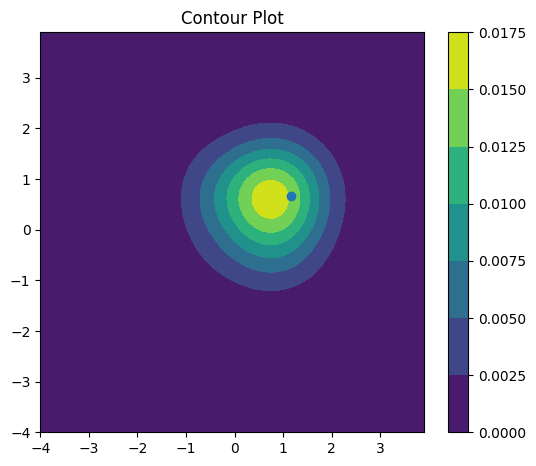

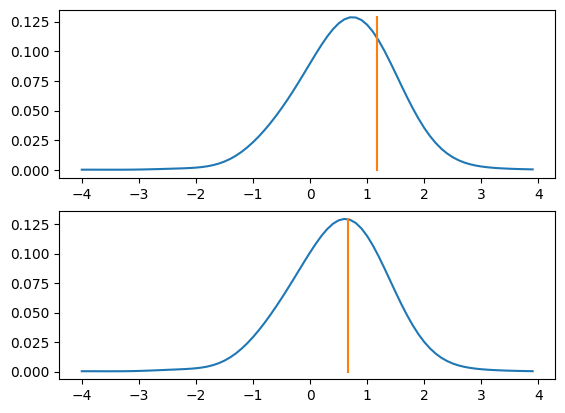

In [ ]:
#Defining the value of h-bar

sf.hbar = 2
hbar = 2

#Defining the classical cost function

def function_optimize(x1, x2):
    y = 2*(x1**2) + 2*x1*x2 - 6*x1 + 2*(x2**2) - 5*x2 + 10
    return y

#Defining the cost unitary used in the QAOA procedure

def cost_ham(q, p):

    Zgate(5*hbar*p) | q[1]
    Pgate(-4*hbar*p) | q[1]
    Zgate(6*hbar*p) | q[0]
    Pgate(-4*hbar*p) | q[0]
    CZgate(-6*hbar*p) | (q[0], q[1])

    return q

#Defining the mixer unitary used in the QAOA process

def mixer_ham(q, p):

    Rgate(-1*math.pi/2) | q[0]
    Rgate(-1*math.pi/2) | q[1]

    Pgate(-1*hbar*p) | q[0]
    Pgate(-1*hbar*p) | q[1]

    Rgate(math.pi/2) | q[0]
    Rgate(math.pi/2) | q[1]

    return q

#Defining circuit depth, cutoff dimension, and squeezing parameter

squeezing = -0.4
cutoff = 6
circuit_depth = 4

#Define the number of iterations that should be sampled from the circuit

shots = 15

#Defining the function that simulates the circuit and returns results

def run_circuit(param):

    eng = sf.Engine("fock", backend_options={"cutoff_dim":cutoff})
    prog = sf.Program(2)

    param1 = [param[0] for i in range(0, circuit_depth)]
    param2 = [param[1] for i in range(0, circuit_depth)]

    with prog.context as q:

        Squeezed(squeezing,0) | q[0]
        Squeezed(squeezing,0) | q[1]

        for i in range(0, circuit_depth):
            if (i%2 == 0):
                cost_ham(q, param1[i])
                mixer_ham(q, param1[i])
            else:
                cost_ham(q, param2[i])
                mixer_ham(q, param2[i])

    state = eng.run(prog, run_options={"eval": False}).state

    a = state.wigner(0, [i/10 for i in range(-40, 40)], [i/10 for i in range(-40, 40)])
    b = state.wigner(1, [i/10 for i in range(-40, 40)], [i/10 for i in range(-40, 40)])

    return [a, b]

#Defining the sampling circuit

def old_circuit(param):

    eng = sf.Engine("fock", backend_options={"cutoff_dim":cutoff})
    prog = sf.Program(2)

    param1 = [param[0] for i in range(0, circuit_depth)]
    param2 = [param[1] for i in range(0, circuit_depth)]

    with prog.context as q:

        Squeezed(squeezing,0) | q[0]
        Squeezed(squeezing,0) | q[1]

        for i in range(0, circuit_depth):
            if (i%2 == 0):
                cost_ham(q, param1[i])
                mixer_ham(q, param1[i])
            else:
                cost_ham(q, param2[i])
                mixer_ham(q, param2[i])


        MeasureX | q[0]
        MeasureX | q[1]

    result = eng.run(prog)
    # return [result.samples[0], result.samples[1]]
    return result.samples[0].tolist()

#Defining the objective function that is optimized

def objective(param):

    costly = 0

    for i in range(0, shots):

        av = old_circuit(param)
        result1 = av[0]
        result2 = av[1]
        calculation = function_optimize(result1, result2)
        costly = costly + calculation

    costly = costly/shots

    print("Paramter: "+str(param))
    print("Value of Cost Function: "+str(costly))

    return costly

#Define the optimizer that is used to find the optimal value of the objective function

out = minimize(objective, x0=[random.randint(-50,50)/100, random.randint(-50,50)/100], method="COBYLA", options={'maxiter':20})
print("-----------------------------")
print(out)

#Defines the sampling method that finds the exact optimal value
samples = 200

optimal_cost = math.inf
optimal_val = 0

for t in range(0, samples):
    final_function = old_circuit(out['x'])
    if (function_optimize(final_function[0], final_function[1]) < optimal_cost):
        optimal_val = final_function
        print(optimal_val)
        optimal_cost = function_optimize(final_function[0], final_function[1])

print("The Optimal Value Is: "+str(optimal_val))


#Define the y array for the first mode

f = run_circuit(out['x'])
final = f[0]

x = [i/10 for i in range(-40, 40)]
y = []

for i in range(0, len(x)):
    res = simps([final[k][i] for k in range(0, len(x))], x)
    y.append(res)

#Define the y array for the second mode

final2 = f[1]

x2 = [i/10 for i in range(-40, 40)]
y2 = []

for i in range(0, len(x2)):
    res = simps([final2[k][i] for k in range(0, len(x2))], x2)
    y2.append(res)


#Defines the contour plot that gives the final probability density function

fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height])

x_vals = x
y_vals = x2
X, Y = np.meshgrid(x, x2)


Z = np.array([[i*j for i in y] for j in y2])

cp = plt.contourf(X, Y, Z)
plt.colorbar(cp)

ax.set_title('Contour Plot')
plt.scatter([float(7)/6], [float(2)/3])
plt.show()

#Defines the probability density graph of the first mode

plt.subplot(2, 1, 1)
plt.plot(x, y)
plt.plot([float(7)/6 for o in range(0, 5)], [0, 0.25*max(y), 0.5*max(y), 0.75*max(y), max(y)])

#Defines the probability density graph of the second mode

plt.subplot(2, 1, 2)
plt.plot(x2, y2)
plt.plot([float(2)/3 for o in range(0, 5)], [0, 0.25*max(y2), 0.5*max(y2), 0.75*max(y2), max(y2)])

plt.show()

So it's not awful, but it isn't amazing either. Even so, I still feel like I'm cheating because I'm still being super selective with the parameters. In addition, this implementation uses a new approach to applying the parameters, where two parameters are optimized, and applied to the circuit in both the mixer and cost unitaries on even and odd numbered iterations respectively. The algorithm does appear to favour a region fairly close to our optimal value, however, there is a lot of variance due to us setting Planck's constant to $2$.

**The Not-So Grand Finale: A Quartic Function With Two Global Minima** <div id="7"></div>

Now, for the grand finale! We will attempt to implement to apply CV QAOA to the optimization of a **quartic** function. However, before we do this, we need to take a bit of a detour, and discuss how the heck we are actually going to create a quartic phase gate.

**Another Small Tangent: Higher-Order Gate Decomposition** <div id="8"></div>

Now, you're probably thinking: "hold on one second....how are we supposed to deal with exponentials of $\hat{x}^4$?". Well, never fear, we actually have a method to decompose this gate exactly, using the research presented by Kalajdzievski and Arrazola in the paper "Exact gate decompositions for photonic quantum computing" (see references for a link to the paper). The paper is genius, if you're interested I **highly** reccomend at least quickly going through it), but we can essentially decompose our quartic gate into a product of a bunch of lower-order gates. I'm not going to go through the proofs/calculations, but, for even $N$, the paper arrives at the relation:

<br><br>
$$e^{i \alpha \hat{x}_k^N} \ = \ e^{2i \alpha \hat{p}_j \hat{x}_k^{N/2}} e^{i \alpha \hat{x}_j^2} e^{-2i \alpha \hat{p}_j \hat{x}_k^{N/2}} e^{-i \alpha \hat{x}_j^2} e^{-2i \alpha \hat{x}_j \hat{x}_k^{N/2}}$$
<br><br>

So for the case of $N \ = \ 4$, we get:

<br><br>
$$e^{i \alpha \hat{x}_k^4} \ = \ e^{2i \alpha \hat{p}_j \hat{x}_k^{2}} e^{i \alpha \hat{x}_j^2} e^{-2i \alpha \hat{p}_j \hat{x}_k^{2}} e^{-i \alpha \hat{x}_j^2} e^{-2i \alpha \hat{x}_j \hat{x}_k^{2}} \ = \ e^{2i \alpha \hat{p}_j \hat{x}_k^{2}} e^{i \alpha \hat{x}_j^2} e^{-2i \alpha \hat{p}_j \hat{x}_k^{2}} e^{-i \alpha \hat{x}_j^2} F^{\dagger}_j e^{-2i \alpha \hat{p}_j \hat{x}_k^{2}} F_j$$
<br><br>

The paper also gives as an identity:

<br><br>
$$e^{i3\beta^2 t \hat{p}_k \hat{x}_j^2} \ = \ e^{i2\beta \hat{x}_j \hat{x}_k} e^{i t \hat{p}_k^3} e^{-i \beta \hat{x}_j \hat{x}_k} e^{-i t \hat{p}_k^3} e^{-i2\beta \hat{x}_j \hat{x}_k} e^{i t \hat{p}_k^3} e^{i \beta \hat{x}_j \hat{x}_k} e^{-i t \hat{p}_k^3} e^{i \beta^3 t \frac{3}{4} \hat{x}^3_j}$$
<br><br>
$$\Rightarrow \ e^{i3 t \hat{p}_k \hat{x}_j^2} \ = \ e^{i2 \hat{x}_j \hat{x}_k} e^{i t \hat{p}_k^3} e^{-i \hat{x}_j \hat{x}_k} e^{-i t \hat{p}_k^3} e^{-i2 \hat{x}_j \hat{x}_k} e^{i t \hat{p}_k^3} e^{i \hat{x}_j \hat{x}_k} e^{-i t \hat{p}_k^3} e^{i t \frac{3}{4} \hat{x}^3_j} \ = \ e^{i2 \hat{x}_j \hat{x}_k} F^{\dagger} e^{-i t \hat{x}_k^3} F e^{-i \hat{x}_j \hat{x}_k} F^{\dagger} e^{i t \hat{x}_k^3} F e^{-i2 \hat{x}_j \hat{x}_k} F^{\dagger} e^{-i t \hat{x}_k^3} F e^{i \hat{x}_j \hat{x}_k} F^{\dagger} e^{i t \hat{x}_k^3} F e^{i t \frac{3}{4} \hat{x}^3_j}$$
<br><br>
$$\Rightarrow e^{i \omega \hat{p}_k \hat{x}_j^2} \ = \ e^{i2 \hat{x}_j \hat{x}_k} F^{\dagger} e^{-i \frac{\omega}{3} \hat{x}_k^3} F e^{-i \hat{x}_j \hat{x}_k} F^{\dagger} e^{i \frac{\omega}{3} \hat{x}_k^3} F e^{-i2 \hat{x}_j \hat{x}_k} F^{\dagger} e^{-i \frac{\omega}{3} \hat{x}_k^3} F e^{i \hat{x}_j \hat{x}_k} F^{\dagger} e^{i \frac{\omega}{3} \hat{x}_k^3} F e^{i \frac{\omega}{4} \hat{x}^3_j}$$
<br><br>

So we have a method to implement gates of the form $e^{i \alpha \hat{p}_k \hat{x}_j^2}$, as well as gates of the form $e^{i \alpha \hat{x}_k \hat{x}_j^2}$ (all we have to do is use a couple Fourier gates). I know, it's a bit of a mess, but we'll break it down, and implement it into our simulation in chunks. We can start by creating a function that generates this specific gate:

In [ ]:
#Implementing the sub-component gate involved in quartic decomposition

def crazy_gate(omega, q, selector):

    Vgate(0.25*3*hbar*omega) | q[selector+1]
    Rgate(math.pi/2) | q[selector]
    Vgate(hbar*omega) | q[selector]
    Rgate(-1*math.pi/2) | q[selector]
    CZgate(hbar) | (q[selector], q[selector+1])
    Rgate(math.pi/2) | q[selector]
    Vgate(-1*hbar*omega) | q[selector]
    Rgate(-1*math.pi/2) | q[selector]
    CZgate(-2*hbar) | (q[selector], q[selector+1])
    Rgate(math.pi/2) | q[selector]
    Vgate(hbar*omega) | q[selector]
    Rgate(-1*math.pi/2) | q[selector]
    CZgate(-1*hbar) | (q[selector], q[selector+1])
    Rgate(math.pi/2) | q[selector]
    Vgate(-1*hbar*omega) | q[selector]
    Rgate(-1*math.pi/2) | q[selector]
    CZgate(2*hbar) | (q[selector], q[selector+1])
    
    return q

We can then construct a function that returns the quartic gate:

In [ ]:
#Defining the quartic gate, in terms of a decomposition

def quartic_gate(q, alpha, selector):

    Rgate(math.pi/2) | q[selector+1]
    crazy_gate(-2*alpha, q, selector)
    Rgate(math.pi/2) | q[selector+1]
    Pgate(-2*hbar*alpha) | q[selector+1]
    crazy_gate(-2*alpha, q, selector)
    Pgate(2*hbar*alpha) | q[selector+1]
    crazy_gate(2*alpha, q, selector)

And that concludes our small detour! Now, let us turn our attention to the function that we wish to optimize, which is:

<br><br>
$$f(x, \ y) \ = \ 0.5x^4 \ - \ 8x^2$$
<br>
$$\text{min} \ f(x, \ y) \ = \ -32 \ \Rightarrow \ x \ = \ \pm \ 2 \sqrt{2}$$
<br><br>

Excellent, so we can now implement our simulation one more time. As usual, we first have to define our value of Planck's constant, ass well as our classical cost function, which will be given as:

In [ ]:
#Defining the value of h-bar

sf.hbar = 1
hbar = 1

#Defining the classical cost function that we are trying to optimize

def function_optimize(x1):
    y = 0.5*(x1**4) - 8*(x1**2)
    return y

Next, we define our cost and mixer unitaries:

In [ ]:
#Defining the cost unitary to be used in QAOA

def cost_ham(q, p):

    quartic_gate(q, -0.5, 0)
    Pgate(16*hbar*p) | q[0]

#Defining the kinetic mixer unitary to be used in QAOA

def mixer_ham(q, p):

    Rgate(-1*math.pi/2) | q[0]
    Pgate(-1*hbar*p) | q[0]
    Rgate(math.pi/2) | q[0]

    return q

We then define our parameters, and our numerical circuit simulator:

In [ ]:
#Defining the depth of the QAOA circuit to be constructed, the squeezing parameter, and the cutoff dimension

circuit_depth = 10
squeezing = -0.5
cutoff = 7


# Defining the function that simulates the circuit, and returns the results

def run_circuit(param):

    eng = sf.Engine("fock", backend_options={"cutoff_dim":cutoff})
    prog = sf.Program(2)

    param1 = [param[0] for i in range(0, circuit_depth)]
    param2 = [param[1] for i in range(0, circuit_depth)]

    with prog.context as q:

        Squeezed(squeezing,0) | q[0]

        for i in range(0, circuit_depth):

            cost_ham(q, param1[i])
            mixer_ham(q, param2[i])

    state = eng.run(prog, run_options={"eval": False}).state
    a = state.wigner(0, [i/100 for i in range(-500, 500)], [i/100 for i in range(-500,500)])

    return a

Now here is where things get interesting.........

**I Promise This is Our Last Detour: Numerically Calculating the Cost Hamiltonian Expectation Value** <div id="9"></div>

The next step of our simulation should be to define our objective function, which we will minimize. Usually we would od this through finite sampling, but in thi case, we will try something new.

Our cost Hamiltonian is of the form:

<br><br>
$$H_{C} \ = \ \hat{x}^4 \ - \ 8\hat{x}^2$$
<br><br>

Thus, when QAOA terminates for each iteration, we want to find, for the prepared state vector $|s\rangle$:

<br><br>
$$\langle H_{C} \rangle \ = \ \langle s | 0.5\hat{x}^4 \ - \ 8\hat{x}^2 | s \rangle$$
<br><br>

Usually, we would have to sample the circuit repeatedly to obtain this expectation value. However, we're going to be sneaky for this simulation, because sampling a circuit this deep will take a nightmarishly long time (not really, but I'm super impatient). We have:

<br><br>
$$\langle s | 0.5\hat{x}^4 \ - \ 8\hat{x}^2 | s \rangle \ = \ 0.5 \langle s | \hat{x}^4 | s \rangle \ - \ 8 \langle s |\hat{x}^2 | s\rangle \ = \  0.5 \displaystyle\int \langle s | x \rangle \langle x | dx \ \hat{x}^4 \displaystyle\int |y \rangle \langle y | s \rangle dy \ - \ 8 \displaystyle\int \langle s | x \rangle \langle x | dx \ \hat{x}^2 \displaystyle\int | y \rangle \langle y | s\rangle dy$$
<br>
$$\Rightarrow \ 0.5 \displaystyle\int \displaystyle\int x^4 \langle s | x \rangle \langle x |y \rangle \langle y | s \rangle \ dy \ dx \ - \ 8 \displaystyle\int \displaystyle\int x^2 \langle s | x \rangle \langle x |y \rangle \langle y | s\rangle \ dy \ dx \ = \ 0.5 \displaystyle\int x^4 \langle s | x \rangle \langle x | s \rangle \ dx \ - \ 8 \displaystyle\int x^2 \langle s | x \rangle \langle x | s \rangle \ dx$$
<br>
$$\Rightarrow \ 0.5 \displaystyle\int x^4 |\langle x | s \rangle|^2 \ dx \ - \ 8 \displaystyle\int x^2 |\langle x | s \rangle|^2 \ dx$$
<br><br>

This tells us something very useful. Essentially, we already know $|\langle x | s \rangle|^2$, this is just the $x$-quadrature probability values. We also already know how to integrate over it numerically, thus, while we take this integral, we simply have multiply either $x^2$ or $x^4$ inside the integrand, and then put the obtained values back into this formula to get the expectation value of the cost Hamiltonian by only evaluating the circuit once! This, technically, is cheating, but we are just experimenting, so I'm going to accept that this is allowed.

Based on what we have just found, we define our new, **numerical** objective function:

In [ ]:
#Defining the objective function that will be minimized by the optimizer

def new_objective(param):

    av = run_circuit(param)

    y = []
    x = [i/100 for i in range(-500, 500)]
    for i in range(0, len(x)):
        res = simps([av[k][i] for k in range(0, len(x))], x)
        y.append(res)

    norm_factor = simps(y, x)
    y = [y[i]/norm_factor for i in range(0, len(y))]

    first_x_2 = [(x[i]**2)*y[i] for i in range(0, len(x))]
    first_x_4 = [(x[i]**4)*y[i] for i in range(0, len(x))]

    i2 = simps(first_x_2, x)
    i3 = simps(first_x_4, x)

    calculation = 0.5*i3 - 8*i2

    print("Value of Cost Function: "+str(calculation))

    return calculation

As you can see, we run the numerical circuit simulator once, and integrate to get expectation values for $x^4$ and $x^2$. You should also notice that we normalize our data points before integrating. This is just due to quartic gates leading to highly unnormalized final states, with ridiculously small values as data points. This leads to Python occasionally getting confused, and thinking it is dividing by $0$ (yes, the probabilities get that small). To get around this issue, we simply normalize the data before we calculate the expectation values.

Finally, we define our optimizer and our visualization:

C:\Users\mhakimi\AppData\Local\Temp\ipykernel_23304\354043049.py:10: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
C:\Users\mhakimi\AppData\Local\Temp\ipykernel_23304\354043049.py:13: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
C:\Users\mhakimi\AppData\Local\Temp\ipykernel_23304\354043049.py:19: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
C:\Users\mhakimi\AppData\Local\Temp\ipykernel_23304\354043049.py:20: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0


Value of Cost Function: -16.070976622275197
Value of Cost Function: -16.11969004157163
Value of Cost Function: -15.05350916027996
Value of Cost Function: -17.608221212018748
Value of Cost Function: -18.446435594551588
Value of Cost Function: -18.804278719562873
Value of Cost Function: -19.001550343932276
Value of Cost Function: -19.107094664005988
Value of Cost Function: -19.132772928716808
Value of Cost Function: -19.14517195451392
Value of Cost Function: -19.12339882427577
Value of Cost Function: -19.151856640711067
Value of Cost Function: -19.156860870731915
Value of Cost Function: -19.160908077291257
Value of Cost Function: -19.165225752905297
Value of Cost Function: -19.16829782932872
Value of Cost Function: -19.171002290629087
Value of Cost Function: -19.17334447461524
Value of Cost Function: -19.170753301491917
Value of Cost Function: -19.175288791630866
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -19.175288791630866


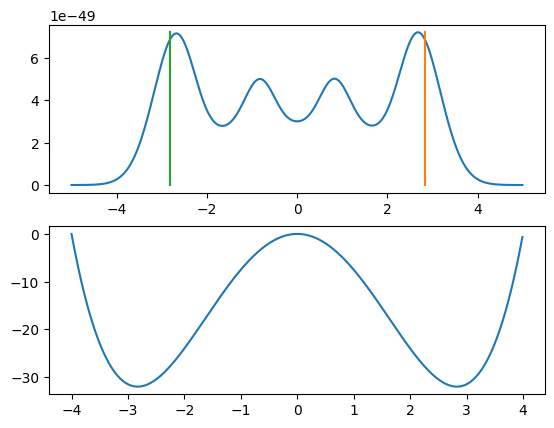

In [ ]:
#Define the optimizer that is used to find the optimal value of the cost function

out = minimize(new_objective, x0=[random.randint(-500,500)/100, random.randint(-500,500)/100], method="COBYLA", options={'maxiter':20})
print(out)

#Runs the circuit a final time, with the optimal parameters

final = run_circuit(out['x'])

#Define the arrays used for the graphical visualization

x = [i/100 for i in range(-500, 500)]
x2 = [i/100 for i in range(-400, 400)]
y = []

#Construct the quadrature graph

for i in range(0, len(x)):
    res = simps([final[k][i] for k in range(0, len(x))], x)
    y.append(res)

plt.subplot(2, 1, 1)
plt.plot(x, y)

#Plot vertical lines corresponding to the actual optimal solutions

plt.plot([2*math.sqrt(2) for i in range(0, 5)], [0, 0.25*max(y), 0.5*max(y), 0.75*max(y), max(y)])
plt.plot([-2*math.sqrt(2) for i in range(0, 5)], [0, 0.25*max(y), 0.5*max(y), 0.75*max(y), max(y)])

#Plot the actual cost function itself

plt.subplot(2, 1, 2)
plt.plot(x2, [function_optimize(x2[i]) for i in range(0, len(x2))])

plt.show()

So we get pretty great results, with two "spikes" appearing at the minima of the cost function. This simulation, however, required a very deep circuit (depth of $8$), so there is definitely a trade-off that must be considered, between accuracy of the algorithms, and dpeth of the circuit (which on a real quantum computer, would lead to loss of coherence).

**Conclusion** <div id="10"></div>

In conclusion, this notebook was meant to act as expository material, to give the reader an idea of what QAOA and CV QAOA are all about through some interesting physical theory in the first section, and concrete simulations in the second part. I really hope you, the reader, has gained more clarity about the power of an algorithm like QAOA (specifically CV QAOA)!

To address to topic of the accuracy of these simulations, I feel like for a lot of these results, I kind of got lucky. When I ran tests locally, I got a lot of great results, but at the same time, I got a lot of not-so-great results. I also feel as though I am "selecting" ideal parameters for each of the simulations, as a lot of the squeezing parameters, cutoff dimensions, etc. that I tested (which I didn't include in this notebook), did not work very well. Nevertheless, I think this is an interesting starting point to dive further into CV QAOA and conceptualize better training techniques, and more general ways to choose parameters such that convergence of the algorithm can be ensured to a higher degree.

**Acknowledgements** <div id="11"></div>

This notebook would not have been compelted without all the help of Guillaume Verdon, Josh Izaac, Nicolas Quesada, Juan Miguel Arrazola, and Nathan Killoran. Thank you to all of you guys, I really appreciate that you took the time to answer my never-ending stream of questions!

**References**

Original CV QAOA Paper: [https://arxiv.org/abs/1902.00409](https://arxiv.org/abs/1902.00409)
<br>
CV Gate Decomposition Paper: [https://arxiv.org/abs/1811.10651](https://arxiv.org/abs/1811.10651)
<br>
The Code for the Contour Graph was Based Off of a StackExchange Answer (Will Update With Link)
<br>
Gaussian Quantum Information: [https://arxiv.org/abs/1110.3234](https://arxiv.org/abs/1110.3234)
<br>
Original QAOA Paper: [https://arxiv.org/abs/1411.4028](https://arxiv.org/abs/1411.4028)
<br>
Basic Explanation of QAE For QC: [https://quantumcomputing.stackexchange.com/a/5572/4907](https://quantumcomputing.stackexchange.com/a/5572/4907)